In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/krisztina/Documents/MLMI/Advanced_ML/BayesianFLowNetworks/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BayesianFlowNetworkDiscrete(nn.Module):
    """
    Bayesian Flow Network for discrete data.
    
    Parameters:
    D (int): dimensionality of data
    K (int): number of classes
    network: network used for predictions for p_output
    beta1 (float): initial beta parameter
    """
    def __init__(self, D=2, K=2, model=None, beta1=3.0):
        super(BayesianFlowNetworkDiscrete, self).__init__()
        self.D = D
        self.K = K
        self.beta1 = beta1

        output_classes=K if K>2 else 1

        if model == None:
            hidden_dim = 128
            self.model = nn.Sequential(
                nn.Linear(D * K + 1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, D * output_classes)
                )
        else:
            self.model = model


    def forward(self, theta, t):
            """
            
            """
            theta = (theta * 2) - 1 # rescale to [-1, 1] to have distribution centered around 0
            theta = theta.view(theta.shape[0], -1) # (B, D*K)
            input_ = torch.cat((theta, t.unsqueeze(-1)), dim=-1) # (B, D*K + 1)
            output = self.model(input_) # (B, D*K)
            output =  output.view(output.shape[0], self.D, -1) # (B, D, K)
            return output


    def discrete_output_distribution(self, theta:torch.Tensor, t:torch.Tensor)->torch.Tensor:
            """
            Parameters:
            theta (torch.Tensor): Input tensor of shape (B, D, K).
            t (torch.Tensor): Time tensor of shape (B,).
            
            Returns:
            p_out (torch.Tensor): Output probability tensor. 
                                  If K=2, tensor shape is (B, D, 2). 
                                  If K>2, tensor shape is (B, D, K).
            """
            net_output = self.forward(theta, t) # (B, D, K)

            if self.K == 2:
                po_1 = torch.sigmoid(net_output) # (B, D, K)
                po_2 = 1 - po_1
                p_out = torch.cat((po_1, po_2), dim=-1) # (B, D, 2)

            else:
                p_out = torch.softmax(net_output, dim=-1) # (B, D, K)

            return p_out
            

    def training_continuous_loss(self, x:torch.Tensor):
            B, D = x.shape

            # Sample t~U(0, 1)
            t = torch.rand((B,), device=x.device, dtype=torch.float32) # (B,)

            # Calculate beta
            beta = self.beta1 * (t**2) # (B,)

            # Sample y from p_sender N(beta*(K * e_x - 1), beta * K * I)
            e_x = F.one_hot(x, num_classes=self.K) # (B, D, K)
            mean = beta.unsqueeze(-1).unsqueeze(-1) * (self.K * e_x.float() - 1) # (B, D, K); beta[:, None, None] for broadcasting
            std = (beta.unsqueeze(-1).unsqueeze(-1) * self.K).sqrt() # (B, D, K)
            # epsilon = torch.rand_like(mean) # (B, D, K)
            # y = mean + std*epsilon # (B, D, K)
            y = torch.distributions.Normal(mean, std).sample() # (B, D, K)

            # Update theta
            theta = torch.softmax(y, dim=-1) # (B, D, K)

            # Calculate p_output
            p_output = self.discrete_output_distribution(theta, t) # (B, D, K)

            # Calculate coninuous Loss
            e_hat = p_output
            Loss_infty = self.K * self.beta1 * t[:, None, None] * ((e_x - e_hat)**2) # (B, D, K)

            return Loss_infty.mean()
        

    @torch.inference_mode()
    def sample(self, batch_size:int, n_steps:int, device='cpu'):
            self.eval()

            # prior theta
            theta = torch.ones(size=(batch_size, self.D, self.K), device=device) / self.K # (batch_size, D, K)

            # generation loop
            for i in range(1, n_steps):
                # Calculate t
                t = (i - 1)/n_steps # scalar
                t = t * torch.ones((theta.shape[0],), device=theta.device, dtype=theta.dtype) # (batch_size,)
                
                # Calculate k
                k_probs = self.discrete_output_distribution(theta, t)  # (B, D, K)
                k = torch.distributions.Categorical(probs=k_probs).sample() # (B, D) # should we do Multinomial??

                # Calculate alpha
                alpha = self.beta1 * ((2*i - 1) / n_steps**2) # scalar

                # Sample y from N(alpha*(K * e_k - 1), alpha * K * I)
                e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, K)
                mean = alpha * (self.K * e_k -1) # (B, D, K)
                var = (alpha * self.K)
                std = torch.full_like(mean, fill_value=var, device=device).sqrt() # (B, D, K)
                # epsilon = torch.randn_like(mean)
                # y = mean + std * epsilon # (B, D, K)
                y = torch.distributions.Normal(mean, std).sample() # (B, D, K)

                # Update theta
                theta_prime = torch.exp(y) * theta # (B, D, K)
                sum_theta_prime = theta_prime.sum(-1, keepdim=True) # (B, D, 1)
                theta = theta_prime / sum_theta_prime # (B, D, K)
            
            k_probs = self.discrete_output_distribution(theta, torch.ones_like(t))  # (B, D, K)
            k_output_sample = torch.distributions.Categorical(probs=k_probs).sample()
            
            return k_output_sample

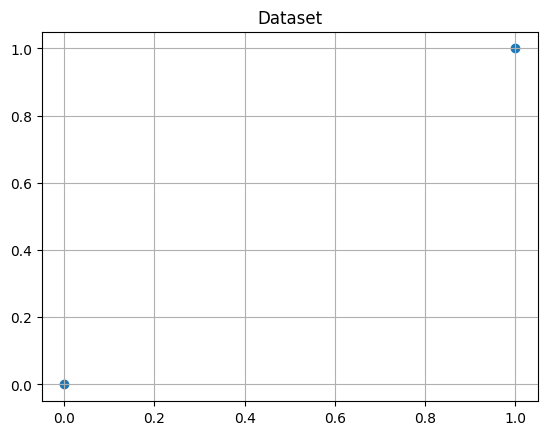

In [3]:
# network should learn
# when x0=0, x1=1
# when x0=1, x1=0

def get_datapoint(batch=128, device="cpu"):
  x0 = torch.randint(low=0, high=2, size=(batch,), dtype=torch.bool, device=device) # (batch,)
  x1 = ~x0

  X = torch.stack([x0, x1], dim=0) # (2, batch)
  return X.long().transpose(0,1) # (batch, 2)

X = get_datapoint() # (B, D=2) K = 2 classes

plt.title("Dataset")
plt.scatter(X[0,:], X[1,:])
plt.grid()

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/krisztina/Documents/MLMI/Advanced_ML/BayesianFLowNetworks/.conda/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1000/1000 [00:02<00:00, 457.13it/s]


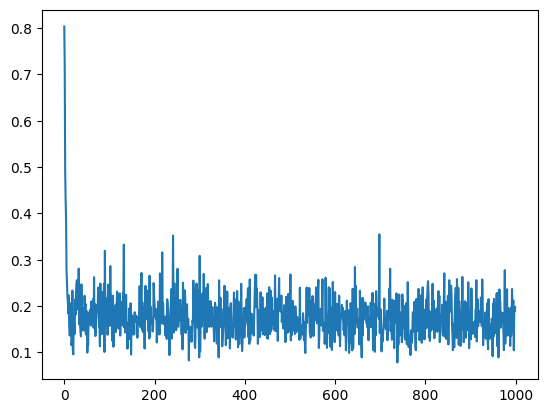

In [7]:
from torch.optim import AdamW
from tqdm.auto import tqdm

bfn = BayesianFlowNetworkDiscrete()
#bfn.cuda()

optim = AdamW(bfn.parameters(), lr=1e-2)

n=1000
losses=[]
for i in tqdm(range(n)):
  optim.zero_grad()

  X = get_datapoint(device="cpu")
  loss = bfn.training_continuous_loss(X)
  loss.backward()

  optim.step()

  losses.append(loss.item())
plt.plot(losses)

In [9]:
x_hat = bfn.sample(batch_size=128, device="cpu", n_steps=1000).cpu().numpy()
x_hat = x_hat + (np.random.randn(*x_hat.shape) * 0.1)

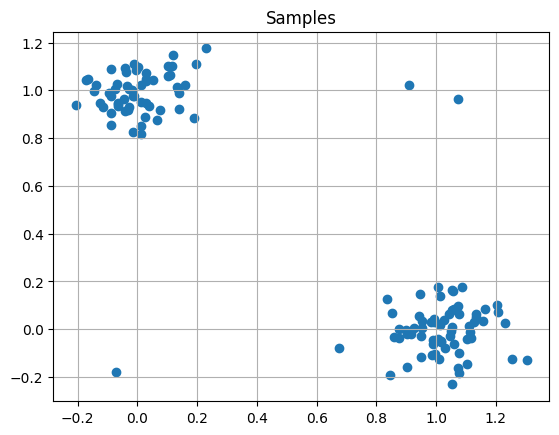

In [10]:
plt.title("Samples")
plt.scatter(x_hat[:, 0], x_hat[:, 1])
plt.grid()